In [6]:
from bvp import our_own_bvp_solve
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
# The following is the system for the midterm.
gamma = 5 / 3
v_plus = 3 / 5
v_star = gamma / (gamma + 2)
e_minus = (gamma + 2) * (v_plus - v_star) / 2 / gamma / (gamma + 1)

# ODE
f = lambda x, y: np.array([y[0] * (y[0] - 1) + gamma * (y[1] - y[0] * e_minus),
                           y[0] * (-(y[0] - 1) ** 2 / 2 + y[1] - e_minus + gamma * e_minus * (y[0] - 1))])

a = 0
b = 20
dim = 2

# Choose an appropriate number of points at which to colocate.
n = 40

In [8]:
# fixed points
source = np.array([1, e_minus])
sink = np.array([0, 0])
saddle = np.array([v_plus, 3 * e_minus])

In [12]:
# These conditions start at the source and move to the sink.
source_to_sink_bc = lambda ya, yb: np.array([
    *(ya[0] - source),          # start at source
    *(yb[0] - sink),            # finish at the sink
    yb[1][0] + yb[1][1] * 0.33  # specify slope at sink
])

# These conditions start at the source and move to the saddle.
source_to_saddle_bc = lambda ya, yb: np.array([
    *(ya[0] - source),         # start at source
    *(yb[0] - saddle),         # finish at saddle
    yb[1][0] + yb[1][1] * 0.6  # specify slope at saddle
])

# These conditions start at the saddle and move to the sink.
saddle_to_sink_bc = lambda ya, yb: np.array([
    *(ya[0] - saddle),          # start at saddle
    *(yb[0] - sink),            # finish at sink
    ya[1][0] + ya[1][1] * -0.3  # specify slope at saddle
])

In [13]:
# initial guess for solution
y0 = np.zeros((n + 1, dim))

# solve for connecting orbits between the three fixed points
source_to_sink_solution = our_own_bvp_solve(f, a, b, n, y0, dim, source_to_sink_bc)
source_to_saddle_solution = our_own_bvp_solve(f, a, b, n, y0, dim, source_to_saddle_bc)
saddle_to_sink_solution = our_own_bvp_solve(f, a, b, n, y0, dim, saddle_to_sink_bc)

/home/kylrth/programming/python/acme436/boundaryvalue/bvp.py:45: RankWarning: The fit may be poorly conditioned
  cf0 = np.polynomial.chebyshev.chebfit(np.linspace(a, b, len(y0)), y0, n)


root finding failed


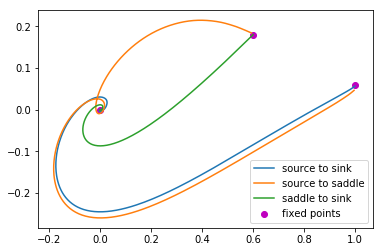

In [14]:
# plotting
dom = np.linspace(a, b, 1000)
plt.plot(source_to_sink_solution[0](dom), source_to_sink_solution[1](dom), label='source to sink')
plt.plot(source_to_saddle_solution[0](dom), source_to_saddle_solution[1](dom), label='source to saddle')
plt.plot(saddle_to_sink_solution[0](dom), saddle_to_sink_solution[1](dom), label='saddle to sink')
plt.scatter([1, 0, 3 / 5], [3 / 50, 0, 9 / 50], color='m', label='fixed points')
plt.legend()
plt.show()